In [1]:
from math import sqrt
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import math
import os
import glob 
from matplotlib import cm 
import pandas as pd
from scipy.stats import binom 
import random

# Things to be discussed
# Plot title
# X,Y axis (title, font size)
# Plot type (bar, line, etc...? )
# Size/ratio

In [2]:
data_name = '1155am'
data_dir = '../Collected data 7_2_1155am'
exp_dir = '.'
#k_join_facts = [1,0.25,0.33,0.5,0.1]
real_times_in_hours = [1,8,23]

# Number of simulation iterations we have run
iters = 50

groups = 3




In [3]:
def get_k_join_facts_and_seed_maxes_for_group(group):
    if group == 0:
        k_join_facts = [0.33,0.5,0.75]
        seed_maxes= [50,400,1500]
    elif group == 1:
        k_join_facts = [1]
        seed_maxes = [50,1000,2000]
    elif group == 2:
        k_join_facts = [0.25,0.1,0.05]
        seed_maxes = [50,200,500]
    return k_join_facts,seed_maxes



In [4]:
def generate_distribution_of_seeds_observed(data_exp1,seed_max,pct_labeled):
    possible_seeds_range= range(1, seed_max)
   
    data_exp = data_exp1
    print("There are " + str(len(data_exp)) + " data points")
    normalized_densities_exp = []
    for possible_seeds in possible_seeds_range:
        normalized_densities_exp.append(0)
    count = 0
    for visible_seeds in data_exp:
        count = count + 1
        if  count%50 == 0:
            print("Analyzed " + str(count) + " samples.")
        densities_exp_one = []
        for possible_seeds in possible_seeds_range:
            density = binom.pmf(visible_seeds, possible_seeds, pct_labeled)
            densities_exp_one.append(density)
        normalized_densities_exp_one = densities_exp_one/sum(densities_exp_one)
        normalized_densities_exp += normalized_densities_exp_one

    normalized_densities_exp = normalized_densities_exp / len(data_exp)
        
    #print(densities_exp)
    # After generating a list for all data points, list will be truncated based on the length of list/length of dataset.

    #chunked_list_exp = list()
    #chunk_size_exp = int(len(normalized_densities_exp)/len(data_exp))

    #for i in range(0,len(normalized_densities_exp), chunk_size_exp):
    #    chunked_list_exp.append(normalized_densities_exp[i:i+chunk_size_exp])

    # Once binom.pmf calculates all data points, and truncated, then now add all lists elementwise.
    #exp_list= [sum(x) for x in zip(*chunked_list_exp)]
    #return exp_list
    return normalized_densities_exp


In [5]:
def get_exp_sizes_for_time(time_in_hrs,seed_max,exp_dir):
    # This cell opens the .dat file and process data

    data_exp1 = open(exp_dir + '/' + str(time_in_hrs) + '_network_seeds.dat')
    data_exp1_network_sizes = data_exp1.read().split('\n')
    data_exp1.close()
    data_exp1 = []
    for seeds in data_exp1_network_sizes:
        if seeds =='':
            continue
        data_exp1.append(int(seeds)/4)
    pct_labeled = 0.25
    normalized_densities_exp = generate_distribution_of_seeds_observed(data_exp1,seed_max,pct_labeled)
    
    return normalized_densities_exp


In [6]:
def get_sim_sizes_for_time_actual(time_in_hrs,k_join_fact,sim_dir):
    # This cell opens the .dat file and process data

    data_sim_fh = open(sim_dir + '/collected_' + str(time_in_hrs) + 'hr_kjoinfact_' + str(k_join_fact) + '_data.dat')
    data_sim_network_sizes = data_sim_fh.read().split('\n')
    data_sim_fh.close()
    data_sim = []
    for seeds in data_sim_network_sizes:
        if seeds =='':
            continue
        data_sim.append(int(seeds))

    return data_sim
    

In [7]:
def generate_experiment_for_sim_data(data_sim,pct_labeled):
    sim_exp_points_per_sim_point = 1
    data_sim_exp = []
    for network_size in data_sim:
        for i in range(sim_exp_points_per_sim_point):
            sim_exp = np.random.binomial(network_size,pct_labeled)
            if sim_exp > 0:
                data_sim_exp.append(sim_exp)
    return data_sim_exp

In [8]:
def get_sim_sizes_for_time(time_in_hrs,seed_max,k_join_fact,sim_dir):
    data_sim = get_sim_sizes_for_time_actual(time_in_hrs,k_join_fact,sim_dir)
        
    pct_labeled = 0.25
    data_sim_exp = generate_experiment_for_sim_data(data_sim,pct_labeled)

    data_hist = generate_distribution_of_seeds_observed(data_sim_exp,seed_max,pct_labeled)
    return data_hist

In [9]:
def create_filename_prefix(hrs,k_join_fact,iters,seed_max):
    prefix = str(hrs) + 'hr_kjoinfact_' + str(k_join_fact) + '_'+ str(iters) + 'iters_to' + str(seed_max) + 'seeds'
    return prefix

In [10]:
def save_data_into_fname(data,fname):
    with open(fname, 'w') as output:
        for element in data:
            output.write(str(element) + '\n')

In [11]:
def save_exp_hist(exp_hist,hrs,k_join_fact,iters,seed_max):
    fname_prefix = create_filename_prefix(hrs,k_join_fact,iters,seed_max)
    fname = fname_prefix + '_expdata.txt'
    save_data_into_fname(exp_hist,fname)
        


In [12]:
def save_sim_hist(sim_hist,hrs,k_join_fact,iters,seed_max):
    fname_prefix = create_filename_prefix(hrs,k_join_fact,iters,seed_max)
    fname = fname_prefix + '_simdata.txt'
    save_data_into_fname(sim_hist,fname)
        

In [13]:
def make_and_save_plot(exp_list,sim_list,hrs,seed_max,k_join_fact):
    # Depict the visualization
    possible_seeds_range = range(1,seed_max)
    plt.plot(possible_seeds_range,sim_list, color ='#2ca02c')
    plt.plot(possible_seeds_range,exp_list, color ='#e377c2')
    if hrs == 1:
        title_string = 'One Hour'
    else:
        title_string = str(hrs) + ' Hours'
    if k_join_fact < 1:
        title_string = title_string + ', K_join multiplied by ' + str(k_join_fact)
    plt.title(title_string)
    plt.xlabel('Seed Counts') 
    plt.ylabel('Normalized Densities') 
    plt.legend(['Simulation','Experiment'])
    fname_prefix = create_filename_prefix(hrs,k_join_fact,iters,seed_max)
    plt.savefig(fname_prefix + '_plot.pdf', format="pdf", bbox_inches="tight")
    plt.show() 

[0.33, 0.5, 0.75]
[50, 400, 1500]
Real time is 1, k_join_fact is 0.33
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 28012 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analy

Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 samples.
Analyzed 19300 samples.
Analyzed 19350 s

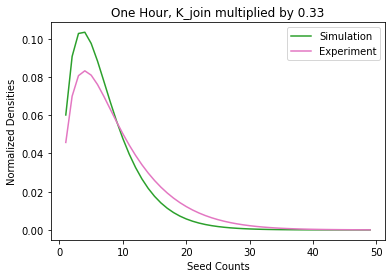

Real time is 8, k_join_fact is 0.33
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 47283 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.

Analyzed 16950 samples.
Analyzed 17000 samples.
Analyzed 17050 samples.
Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 s

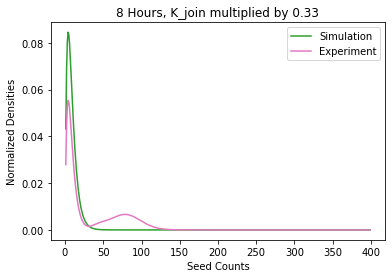

Real time is 23, k_join_fact is 0.33
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 74766 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 sam

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 samples.
Analyzed 36250 s

Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 samples.
Analyzed 53200 samples.
Analyzed 53250 samples.
Analyzed 53300 samples.
Analyzed 53350 s

Analyzed 68400 samples.
Analyzed 68450 samples.
Analyzed 68500 samples.
Analyzed 68550 samples.
Analyzed 68600 samples.
Analyzed 68650 samples.
Analyzed 68700 samples.
Analyzed 68750 samples.
Analyzed 68800 samples.
Analyzed 68850 samples.
Analyzed 68900 samples.
Analyzed 68950 samples.
Analyzed 69000 samples.
Analyzed 69050 samples.
Analyzed 69100 samples.
Analyzed 69150 samples.
Analyzed 69200 samples.
Analyzed 69250 samples.
Analyzed 69300 samples.
Analyzed 69350 samples.
Analyzed 69400 samples.
Analyzed 69450 samples.
Analyzed 69500 samples.
Analyzed 69550 samples.
Analyzed 69600 samples.
Analyzed 69650 samples.
Analyzed 69700 samples.
Analyzed 69750 samples.
Analyzed 69800 samples.
Analyzed 69850 samples.
Analyzed 69900 samples.
Analyzed 69950 samples.
Analyzed 70000 samples.
Analyzed 70050 samples.
Analyzed 70100 samples.
Analyzed 70150 samples.
Analyzed 70200 samples.
Analyzed 70250 samples.
Analyzed 70300 samples.
Analyzed 70350 samples.
Analyzed 70400 samples.
Analyzed 70450 s

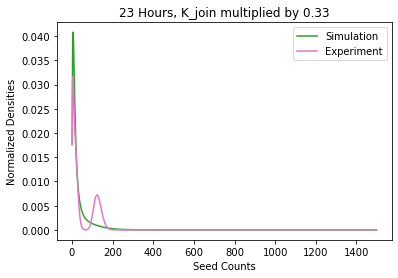

Real time is 1, k_join_fact is 0.5
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 29417 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyzed 1750 samples.
Analyzed 1800 sam

Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 samples.
Analyzed 19300 samples.
Analyzed 19350 samples.
Analyzed 19400 s

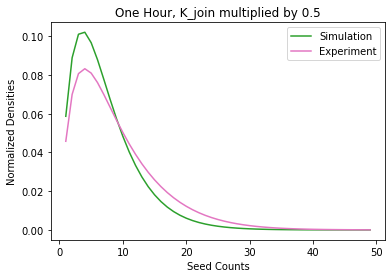

Real time is 8, k_join_fact is 0.5
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 57093 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.


Analyzed 16900 samples.
Analyzed 16950 samples.
Analyzed 17000 samples.
Analyzed 17050 samples.
Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 s

Analyzed 34000 samples.
Analyzed 34050 samples.
Analyzed 34100 samples.
Analyzed 34150 samples.
Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 s

Analyzed 51100 samples.
Analyzed 51150 samples.
Analyzed 51200 samples.
Analyzed 51250 samples.
Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 s

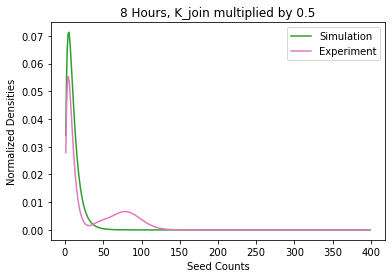

Real time is 23, k_join_fact is 0.5
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 84507 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samp

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 samples.
Analyzed 36250 s

Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 samples.
Analyzed 53200 samples.
Analyzed 53250 samples.
Analyzed 53300 samples.
Analyzed 53350 s

Analyzed 68400 samples.
Analyzed 68450 samples.
Analyzed 68500 samples.
Analyzed 68550 samples.
Analyzed 68600 samples.
Analyzed 68650 samples.
Analyzed 68700 samples.
Analyzed 68750 samples.
Analyzed 68800 samples.
Analyzed 68850 samples.
Analyzed 68900 samples.
Analyzed 68950 samples.
Analyzed 69000 samples.
Analyzed 69050 samples.
Analyzed 69100 samples.
Analyzed 69150 samples.
Analyzed 69200 samples.
Analyzed 69250 samples.
Analyzed 69300 samples.
Analyzed 69350 samples.
Analyzed 69400 samples.
Analyzed 69450 samples.
Analyzed 69500 samples.
Analyzed 69550 samples.
Analyzed 69600 samples.
Analyzed 69650 samples.
Analyzed 69700 samples.
Analyzed 69750 samples.
Analyzed 69800 samples.
Analyzed 69850 samples.
Analyzed 69900 samples.
Analyzed 69950 samples.
Analyzed 70000 samples.
Analyzed 70050 samples.
Analyzed 70100 samples.
Analyzed 70150 samples.
Analyzed 70200 samples.
Analyzed 70250 samples.
Analyzed 70300 samples.
Analyzed 70350 samples.
Analyzed 70400 samples.
Analyzed 70450 s

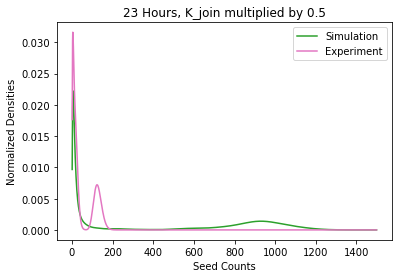

Real time is 1, k_join_fact is 0.75
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 31479 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyzed 1750 samples.
Analyzed 1800 sa

Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 s

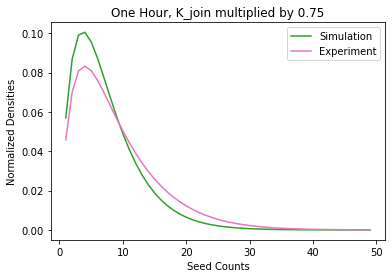

Real time is 8, k_join_fact is 0.75
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 68271 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.

Analyzed 16900 samples.
Analyzed 16950 samples.
Analyzed 17000 samples.
Analyzed 17050 samples.
Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 s

Analyzed 51100 samples.
Analyzed 51150 samples.
Analyzed 51200 samples.
Analyzed 51250 samples.
Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 s

Analyzed 68250 samples.


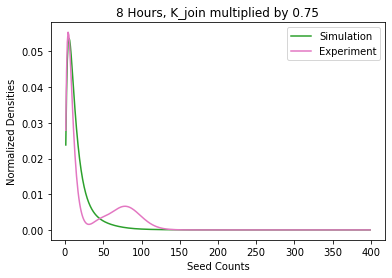

Real time is 23, k_join_fact is 0.75
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 90958 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 sam

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 samples.
Analyzed 36250 s

Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 samples.
Analyzed 53200 samples.
Analyzed 53250 samples.
Analyzed 53300 samples.
Analyzed 53350 s

Analyzed 68400 samples.
Analyzed 68450 samples.
Analyzed 68500 samples.
Analyzed 68550 samples.
Analyzed 68600 samples.
Analyzed 68650 samples.
Analyzed 68700 samples.
Analyzed 68750 samples.
Analyzed 68800 samples.
Analyzed 68850 samples.
Analyzed 68900 samples.
Analyzed 68950 samples.
Analyzed 69000 samples.
Analyzed 69050 samples.
Analyzed 69100 samples.
Analyzed 69150 samples.
Analyzed 69200 samples.
Analyzed 69250 samples.
Analyzed 69300 samples.
Analyzed 69350 samples.
Analyzed 69400 samples.
Analyzed 69450 samples.
Analyzed 69500 samples.
Analyzed 69550 samples.
Analyzed 69600 samples.
Analyzed 69650 samples.
Analyzed 69700 samples.
Analyzed 69750 samples.
Analyzed 69800 samples.
Analyzed 69850 samples.
Analyzed 69900 samples.
Analyzed 69950 samples.
Analyzed 70000 samples.
Analyzed 70050 samples.
Analyzed 70100 samples.
Analyzed 70150 samples.
Analyzed 70200 samples.
Analyzed 70250 samples.
Analyzed 70300 samples.
Analyzed 70350 samples.
Analyzed 70400 samples.
Analyzed 70450 s

Analyzed 85500 samples.
Analyzed 85550 samples.
Analyzed 85600 samples.
Analyzed 85650 samples.
Analyzed 85700 samples.
Analyzed 85750 samples.
Analyzed 85800 samples.
Analyzed 85850 samples.
Analyzed 85900 samples.
Analyzed 85950 samples.
Analyzed 86000 samples.
Analyzed 86050 samples.
Analyzed 86100 samples.
Analyzed 86150 samples.
Analyzed 86200 samples.
Analyzed 86250 samples.
Analyzed 86300 samples.
Analyzed 86350 samples.
Analyzed 86400 samples.
Analyzed 86450 samples.
Analyzed 86500 samples.
Analyzed 86550 samples.
Analyzed 86600 samples.
Analyzed 86650 samples.
Analyzed 86700 samples.
Analyzed 86750 samples.
Analyzed 86800 samples.
Analyzed 86850 samples.
Analyzed 86900 samples.
Analyzed 86950 samples.
Analyzed 87000 samples.
Analyzed 87050 samples.
Analyzed 87100 samples.
Analyzed 87150 samples.
Analyzed 87200 samples.
Analyzed 87250 samples.
Analyzed 87300 samples.
Analyzed 87350 samples.
Analyzed 87400 samples.
Analyzed 87450 samples.
Analyzed 87500 samples.
Analyzed 87550 s

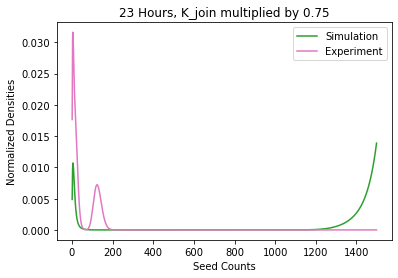

[1]
[50, 1000, 2000]
Real time is 1, k_join_fact is 1
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 33860 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyzed 1750 samples

Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 samples.
Analyzed 19300 samples.
Analyzed 19350 samples.
Analyzed 19400 s

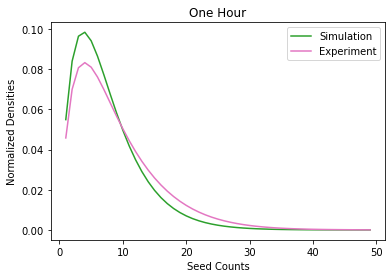

Real time is 8, k_join_fact is 1
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 76246 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
An

Analyzed 16900 samples.
Analyzed 16950 samples.
Analyzed 17000 samples.
Analyzed 17050 samples.
Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 s

Analyzed 34000 samples.
Analyzed 34050 samples.
Analyzed 34100 samples.
Analyzed 34150 samples.
Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 s

Analyzed 51100 samples.
Analyzed 51150 samples.
Analyzed 51200 samples.
Analyzed 51250 samples.
Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 s

Analyzed 68200 samples.
Analyzed 68250 samples.
Analyzed 68300 samples.
Analyzed 68350 samples.
Analyzed 68400 samples.
Analyzed 68450 samples.
Analyzed 68500 samples.
Analyzed 68550 samples.
Analyzed 68600 samples.
Analyzed 68650 samples.
Analyzed 68700 samples.
Analyzed 68750 samples.
Analyzed 68800 samples.
Analyzed 68850 samples.
Analyzed 68900 samples.
Analyzed 68950 samples.
Analyzed 69000 samples.
Analyzed 69050 samples.
Analyzed 69100 samples.
Analyzed 69150 samples.
Analyzed 69200 samples.
Analyzed 69250 samples.
Analyzed 69300 samples.
Analyzed 69350 samples.
Analyzed 69400 samples.
Analyzed 69450 samples.
Analyzed 69500 samples.
Analyzed 69550 samples.
Analyzed 69600 samples.
Analyzed 69650 samples.
Analyzed 69700 samples.
Analyzed 69750 samples.
Analyzed 69800 samples.
Analyzed 69850 samples.
Analyzed 69900 samples.
Analyzed 69950 samples.
Analyzed 70000 samples.
Analyzed 70050 samples.
Analyzed 70100 samples.
Analyzed 70150 samples.
Analyzed 70200 samples.
Analyzed 70250 s

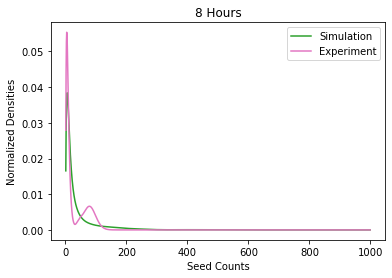

Real time is 23, k_join_fact is 1
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 94233 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 sample

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 samples.
Analyzed 36250 s

Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 samples.
Analyzed 53200 samples.
Analyzed 53250 samples.
Analyzed 53300 samples.
Analyzed 53350 s

Analyzed 68400 samples.
Analyzed 68450 samples.
Analyzed 68500 samples.
Analyzed 68550 samples.
Analyzed 68600 samples.
Analyzed 68650 samples.
Analyzed 68700 samples.
Analyzed 68750 samples.
Analyzed 68800 samples.
Analyzed 68850 samples.
Analyzed 68900 samples.
Analyzed 68950 samples.
Analyzed 69000 samples.
Analyzed 69050 samples.
Analyzed 69100 samples.
Analyzed 69150 samples.
Analyzed 69200 samples.
Analyzed 69250 samples.
Analyzed 69300 samples.
Analyzed 69350 samples.
Analyzed 69400 samples.
Analyzed 69450 samples.
Analyzed 69500 samples.
Analyzed 69550 samples.
Analyzed 69600 samples.
Analyzed 69650 samples.
Analyzed 69700 samples.
Analyzed 69750 samples.
Analyzed 69800 samples.
Analyzed 69850 samples.
Analyzed 69900 samples.
Analyzed 69950 samples.
Analyzed 70000 samples.
Analyzed 70050 samples.
Analyzed 70100 samples.
Analyzed 70150 samples.
Analyzed 70200 samples.
Analyzed 70250 samples.
Analyzed 70300 samples.
Analyzed 70350 samples.
Analyzed 70400 samples.
Analyzed 70450 s

Analyzed 85500 samples.
Analyzed 85550 samples.
Analyzed 85600 samples.
Analyzed 85650 samples.
Analyzed 85700 samples.
Analyzed 85750 samples.
Analyzed 85800 samples.
Analyzed 85850 samples.
Analyzed 85900 samples.
Analyzed 85950 samples.
Analyzed 86000 samples.
Analyzed 86050 samples.
Analyzed 86100 samples.
Analyzed 86150 samples.
Analyzed 86200 samples.
Analyzed 86250 samples.
Analyzed 86300 samples.
Analyzed 86350 samples.
Analyzed 86400 samples.
Analyzed 86450 samples.
Analyzed 86500 samples.
Analyzed 86550 samples.
Analyzed 86600 samples.
Analyzed 86650 samples.
Analyzed 86700 samples.
Analyzed 86750 samples.
Analyzed 86800 samples.
Analyzed 86850 samples.
Analyzed 86900 samples.
Analyzed 86950 samples.
Analyzed 87000 samples.
Analyzed 87050 samples.
Analyzed 87100 samples.
Analyzed 87150 samples.
Analyzed 87200 samples.
Analyzed 87250 samples.
Analyzed 87300 samples.
Analyzed 87350 samples.
Analyzed 87400 samples.
Analyzed 87450 samples.
Analyzed 87500 samples.
Analyzed 87550 s

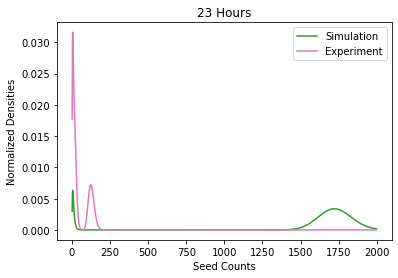

[0.25, 0.1, 0.05]
[50, 200, 500]
Real time is 1, k_join_fact is 0.25
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 27171 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyz

Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 s

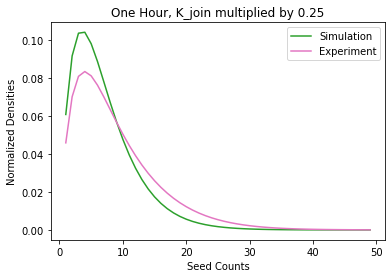

Real time is 8, k_join_fact is 0.25
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 42416 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.

Analyzed 33900 samples.
Analyzed 33950 samples.
Analyzed 34000 samples.
Analyzed 34050 samples.
Analyzed 34100 samples.
Analyzed 34150 samples.
Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 s

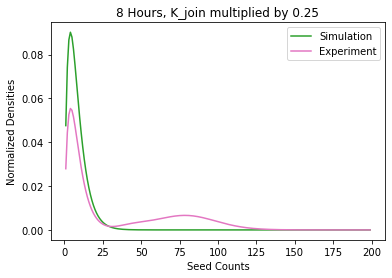

Real time is 23, k_join_fact is 0.25
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 67218 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 sam

Analyzed 34150 samples.
Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 s

Analyzed 51250 samples.
Analyzed 51300 samples.
Analyzed 51350 samples.
Analyzed 51400 samples.
Analyzed 51450 samples.
Analyzed 51500 samples.
Analyzed 51550 samples.
Analyzed 51600 samples.
Analyzed 51650 samples.
Analyzed 51700 samples.
Analyzed 51750 samples.
Analyzed 51800 samples.
Analyzed 51850 samples.
Analyzed 51900 samples.
Analyzed 51950 samples.
Analyzed 52000 samples.
Analyzed 52050 samples.
Analyzed 52100 samples.
Analyzed 52150 samples.
Analyzed 52200 samples.
Analyzed 52250 samples.
Analyzed 52300 samples.
Analyzed 52350 samples.
Analyzed 52400 samples.
Analyzed 52450 samples.
Analyzed 52500 samples.
Analyzed 52550 samples.
Analyzed 52600 samples.
Analyzed 52650 samples.
Analyzed 52700 samples.
Analyzed 52750 samples.
Analyzed 52800 samples.
Analyzed 52850 samples.
Analyzed 52900 samples.
Analyzed 52950 samples.
Analyzed 53000 samples.
Analyzed 53050 samples.
Analyzed 53100 samples.
Analyzed 53150 samples.
Analyzed 53200 samples.
Analyzed 53250 samples.
Analyzed 53300 s

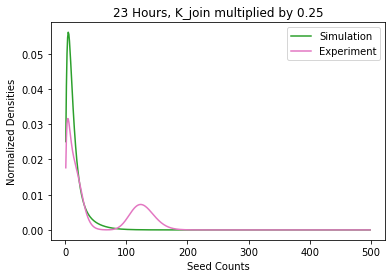

Real time is 1, k_join_fact is 0.1
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 25873 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyzed 1750 samples.
Analyzed 1800 sam

Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 samples.
Analyzed 19300 samples.
Analyzed 19350 samples.
Analyzed 19400 s

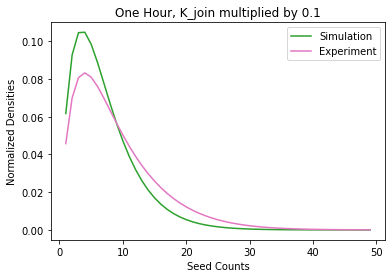

Real time is 8, k_join_fact is 0.1
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 32023 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.


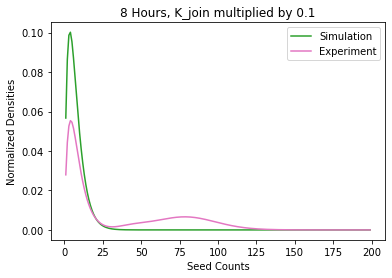

Real time is 23, k_join_fact is 0.1
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 44776 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samp

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.
Analyzed 35350 samples.
Analyzed 35400 samples.
Analyzed 35450 samples.
Analyzed 35500 samples.
Analyzed 35550 samples.
Analyzed 35600 samples.
Analyzed 35650 samples.
Analyzed 35700 samples.
Analyzed 35750 samples.
Analyzed 35800 samples.
Analyzed 35850 samples.
Analyzed 35900 samples.
Analyzed 35950 samples.
Analyzed 36000 samples.
Analyzed 36050 samples.
Analyzed 36100 samples.
Analyzed 36150 samples.
Analyzed 36200 samples.
Analyzed 36250 s

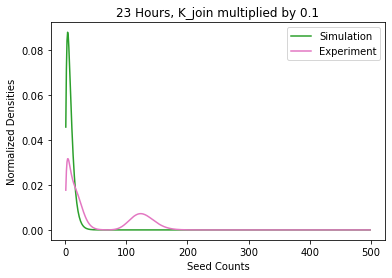

Real time is 1, k_join_fact is 0.05
There are 284 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
There are 25330 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 samples.
Analyzed 1750 samples.
Analyzed 1800 sa

Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 samples.
Analyzed 19200 samples.
Analyzed 19250 s

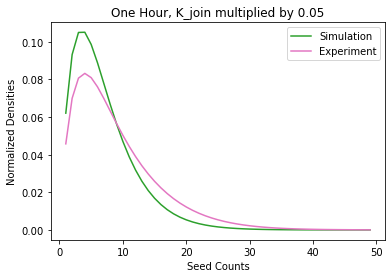

Real time is 8, k_join_fact is 0.05
There are 564 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
There are 28514 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.

Analyzed 16900 samples.
Analyzed 16950 samples.
Analyzed 17000 samples.
Analyzed 17050 samples.
Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 s

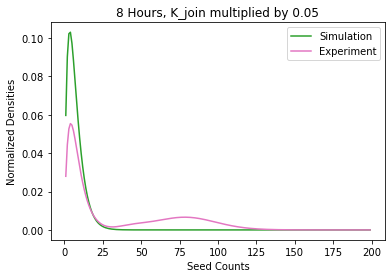

Real time is 23, k_join_fact is 0.05
There are 354 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
There are 35333 data points
Analyzed 50 samples.
Analyzed 100 samples.
Analyzed 150 samples.
Analyzed 200 samples.
Analyzed 250 samples.
Analyzed 300 samples.
Analyzed 350 samples.
Analyzed 400 samples.
Analyzed 450 samples.
Analyzed 500 samples.
Analyzed 550 samples.
Analyzed 600 samples.
Analyzed 650 samples.
Analyzed 700 samples.
Analyzed 750 samples.
Analyzed 800 samples.
Analyzed 850 samples.
Analyzed 900 samples.
Analyzed 950 samples.
Analyzed 1000 samples.
Analyzed 1050 samples.
Analyzed 1100 samples.
Analyzed 1150 samples.
Analyzed 1200 samples.
Analyzed 1250 samples.
Analyzed 1300 samples.
Analyzed 1350 samples.
Analyzed 1400 samples.
Analyzed 1450 samples.
Analyzed 1500 samples.
Analyzed 1550 samples.
Analyzed 1600 samples.
Analyzed 1650 samples.
Analyzed 1700 sam

Analyzed 17100 samples.
Analyzed 17150 samples.
Analyzed 17200 samples.
Analyzed 17250 samples.
Analyzed 17300 samples.
Analyzed 17350 samples.
Analyzed 17400 samples.
Analyzed 17450 samples.
Analyzed 17500 samples.
Analyzed 17550 samples.
Analyzed 17600 samples.
Analyzed 17650 samples.
Analyzed 17700 samples.
Analyzed 17750 samples.
Analyzed 17800 samples.
Analyzed 17850 samples.
Analyzed 17900 samples.
Analyzed 17950 samples.
Analyzed 18000 samples.
Analyzed 18050 samples.
Analyzed 18100 samples.
Analyzed 18150 samples.
Analyzed 18200 samples.
Analyzed 18250 samples.
Analyzed 18300 samples.
Analyzed 18350 samples.
Analyzed 18400 samples.
Analyzed 18450 samples.
Analyzed 18500 samples.
Analyzed 18550 samples.
Analyzed 18600 samples.
Analyzed 18650 samples.
Analyzed 18700 samples.
Analyzed 18750 samples.
Analyzed 18800 samples.
Analyzed 18850 samples.
Analyzed 18900 samples.
Analyzed 18950 samples.
Analyzed 19000 samples.
Analyzed 19050 samples.
Analyzed 19100 samples.
Analyzed 19150 s

Analyzed 34200 samples.
Analyzed 34250 samples.
Analyzed 34300 samples.
Analyzed 34350 samples.
Analyzed 34400 samples.
Analyzed 34450 samples.
Analyzed 34500 samples.
Analyzed 34550 samples.
Analyzed 34600 samples.
Analyzed 34650 samples.
Analyzed 34700 samples.
Analyzed 34750 samples.
Analyzed 34800 samples.
Analyzed 34850 samples.
Analyzed 34900 samples.
Analyzed 34950 samples.
Analyzed 35000 samples.
Analyzed 35050 samples.
Analyzed 35100 samples.
Analyzed 35150 samples.
Analyzed 35200 samples.
Analyzed 35250 samples.
Analyzed 35300 samples.


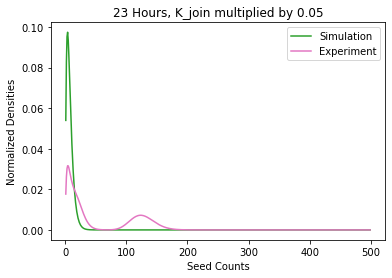

In [14]:

for g in range(groups):
    k_join_facts,seed_maxes = get_k_join_facts_and_seed_maxes_for_group(g)
    print(k_join_facts)
    print(seed_maxes)
    for k_join_fact in k_join_facts:
        for i in range(len(real_times_in_hours)):
            real_time_in_hours = real_times_in_hours[i]
            seed_max = seed_maxes[i]
            print("Real time is " + str(real_time_in_hours) + ", k_join_fact is " + str(k_join_fact))
            exp_hist = get_exp_sizes_for_time(real_time_in_hours,seed_max,exp_dir)
            save_exp_hist(exp_hist,real_time_in_hours,k_join_fact,iters,seed_max)
            sim_hist = get_sim_sizes_for_time(real_time_in_hours,seed_max,k_join_fact,data_dir)
            save_sim_hist(sim_hist,real_time_in_hours,k_join_fact,iters,seed_max)
            make_and_save_plot(exp_hist,sim_hist,real_time_in_hours,seed_max,k_join_fact)
                

In [15]:
len(sim_hist)

499